Импортим всякую дичь

In [1]:
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet

print('\n> Changing the dir to:')
% cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install Pillow
! pip install pytesseract
import warnings
warnings.filterwarnings('ignore')
import pytesseract
from skimage.io import imread, imsave
from PIL import Image


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (614/614), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 614 (delta 268), reused 543 (delta 220), pack-reused 0
Receiving objects: 100% (614/614), 11.87 MiB | 19.45 MiB/s, done.
Resolving deltas: 100% (268/268), done.

> Install dependencies
     |████████████████████████████████| 12.5 MB 7.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 72 kB 631 kB/s 
     |████████████████████████████████| 144 kB 52.0 MB/s 
     |████████████████████████████████| 841 kB 35.7 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
     |████████████████████████████████| 47 kB 4.3 MB/s 
     |████████████████████████████████| 47.6 MB 32 kB/s 
     |████████████████████████████████| 948 kB 46.3 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB

Загружаем файл 


In [43]:
try:
    image = Image.open("/content/8ceice.png")
except FileNotFoundError:
    print("Файл не найден")

In [44]:
print("Размер изображения:")  
y = image.size[1]
x = image.size[0]
print(image.format, image.size, image.mode)
print(x, y)

Размер изображения:
PNG (1128, 760) RGB
1128 760


In [45]:
pytesseract.image_to_string(image)

' \n\x0c'

In [46]:
a = []
b = []
data = pytesseract.image_to_boxes(image)
for el in data.splitlines():
  # print(el)
  a.append(el.split(" "))
a.pop(0)
a.pop(len(a)-1)
for i in a:
  i.pop(0)
  i.pop(4)
  i = [int(item) for item in i]
  b.append(i)

c = np.array(b)
c










IndexError: ignored

In [35]:
image = np.array(image)
image.shape

(756, 1125, 3)

In [41]:
mask_0 = np.zeros((y, x, 3))
# mask_0 = 255 * mask_0 # Now scale by 255
# mask_0 = mask_0.astype(np.uint8)
maska = np.zeros((y, x, 3))
for i in c:
  maska[y-i[3]-5:y-i[1]+7, i[0]-8:i[2]+10, :] = 1
  
mask_0 = maska

mask_0 = 255 * mask_0 # Now scale by 255
img = mask_0.astype(np.uint8)


imsave('/content/mask.png', mask_0)
# plt.imshow(mask_0)
mask_0.shape







(756, 1125, 3)

In [37]:
mask = mask_0

Will use ./data_for_prediction/8ce.jpg for inpainting


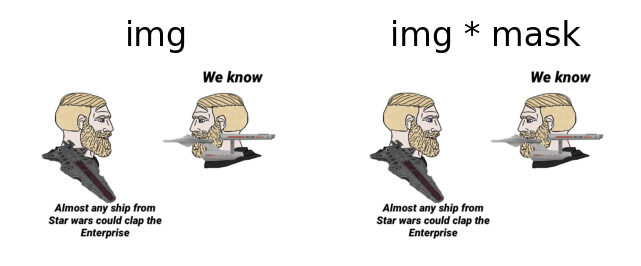

Run inpainting
100% 1/1 [00:01<00:00,  1.53s/it]


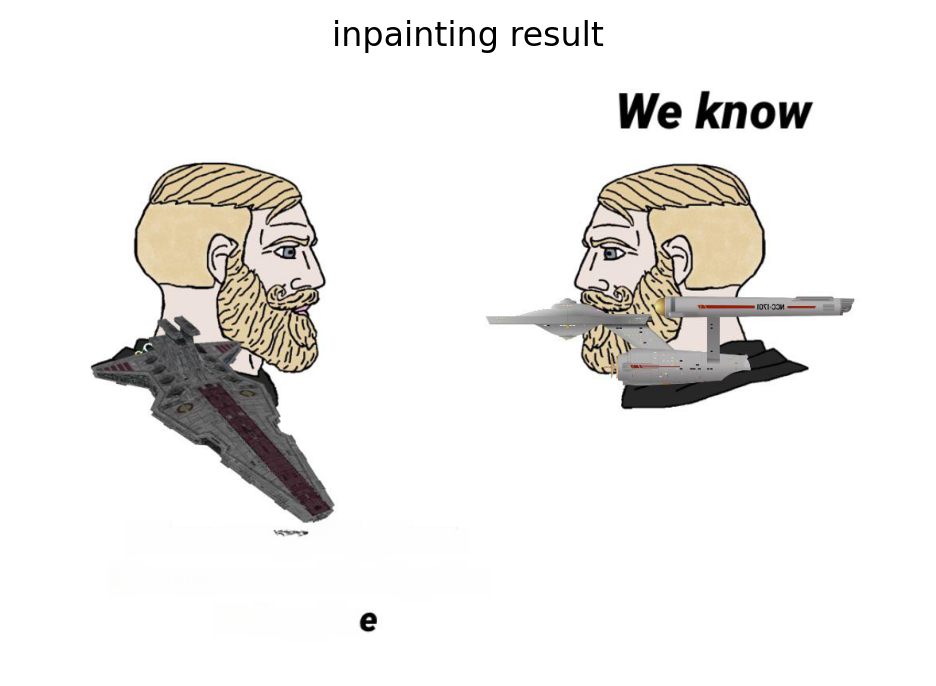

In [42]:
fname = '8ceice.png'
shutil.copyfile('/content/{}'.format(fname), './{}'.format(fname))
shutil.rmtree('./data_for_prediction', ignore_errors=True)
! mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

shutil.copyfile('/content/mask.png', f"./{fname.split('.')[1]}_mask.png".format(fname))
mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png".format(fname)))
mask = (mask[:,:,0]==1)*(mask[:,:,1]==0)*(mask[:,:,2]==0)


plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None